Dans ce billet, nous allons extraire les données disponibles sur les scrutins de l'assemblée nationale afin de déterminer quels jours de la semaine sont propice au débat dans l'assemblée et quels jours ne le sont pas.

# Récupération des informations 

Les données qui m'intéressent sont sur la page suivante : [http://www2.assemblee-nationale.fr/scrutins/liste/%28legislature%29/14](http://www2.assemblee-nationale.fr/scrutins/liste/%28legislature%29/14).

Téléchargeons le contenu de cette page.

In [1]:
import requests

In [2]:
r = requests.get("http://www2.assemblee-nationale.fr/scrutins/liste/%28legislature%29/14")
r

<Response [200]>

Maintenant, passons la page dans le parser BeautifulSoup :

In [3]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(r.text, 'html.parser')

Les éléments qui nous intéressent sont les suivants : 

- numéro du scrutin
- date du scrutin
- objet du scrutin
- résultats : pour, contre, abstention volontaire

Ces éléments sont dans un grand tableau, que nous allons essayer d'extraire :

In [4]:
elems = soup.select('tbody tr')

In [5]:
len(elems)

100

Chaque élément précédent représente une ligne du tableau. La première ligne du tableau contient par exemple les informations suivantes :

In [6]:
elems[0]

<tr>
<td class="denom">1237*</td>
<td>10/02/2016</td>
<td class="desc">l'ensemble du projet de loi constitutionnelle de protection de la Nation (première lecture). [<a href="http://www.assemblee-nationale.fr/14/dossiers/protection_nation.asp">dossier</a>] [<a href="/scrutins/detail/(legislature)/14/(num)/1237">analyse du scrutin</a>]</td>
<td class="pour">317</td>
<td class="contre SSO">199</td>
<td class="abs SSO">51</td>
</tr>

Ecrivons une fonction qui extrait les informations d'une seule ligne.

In [7]:
def extract_information(line):
    """Extrait les informations d'une ligne du tableau des scrutins."""
    elems = line.find_all('td')
    # numéro de scrutin
    num = elems[0].text
    # date
    date = elems[1].text
    # objet
    obj = elems[2].text
    # pour
    pour = int(elems[3].text)
    # contre
    contre = int(elems[4].text)
    # abstention
    abstention = int(elems[5].text)
    return num, date, obj, pour, contre, abstention

On peut tester cette routine sur la première ligne :

In [8]:
extract_information(elems[0])

('1237*',
 '10/02/2016',
 "l'ensemble du projet de loi constitutionnelle de protection de la Nation (première lecture). [dossier] [analyse du scrutin]",
 317,
 199,
 51)

Répétons cette extraction pour chaque ligne :

In [9]:
data = [extract_information(line) for line in elems]

Comme on peut le voir, cela marche plutôt bien. Nous allons maintenant traiter ces informations avec `pandas`.

# Utilisation de pandas 

Nous pouvons directement importer les données précédentes dans un objet dataframe, qui va nous simplifier les démarches :

In [10]:
import pandas as pd

In [11]:
df = pd.DataFrame(data, columns=('numero', 'date', 'objet', 'pour', 'contre', 'abstention'))
df.head(10)

,numero,date,objet,pour,contre,abstention
0,1237*,10/02/2016,l'ensemble du projet de loi constitutionnelle ...,317,199,51
1,1236,09/02/2016,l'ensemble de l'article premier du projet de l...,116,19,11
2,1235,09/02/2016,l'amendement n° 1 du Gouvernement à l'article ...,132,7,7
3,1234,09/02/2016,l'amendement n° 2 du Gouvernement à l'article ...,104,34,7
4,1233,09/02/2016,l'amendement n° 234 de M. Hamon après l'articl...,61,97,3
5,1232,09/02/2016,l'amendement n° 168 de M. Hamon après l'articl...,67,103,2
6,1231,09/02/2016,l'article 2 du projet de loi constitutionnelle...,162,148,22
7,1230,09/02/2016,le sous-amendement n° 271 de Mme Duflot et les...,59,185,25
8,1229,09/02/2016,le sous-amendement n° 250 de M. Goldberg et le...,77,174,32
9,1228,09/02/2016,l'amendement n° 50 de M. Schwartzenberg à l'ar...,64,180,41


A partir de ce tableau, nous pouvons calculer le nombre de d'absents, car il y a 577 députés à l'assemblée nationale.

In [12]:
df['presents'] = df['pour'] + df['contre'] + df['abstention']
df['absents'] = 577 - df.presents

In [13]:
df.head(10)

,numero,date,objet,pour,contre,abstention,presents,absents
0,1237*,10/02/2016,l'ensemble du projet de loi constitutionnelle ...,317,199,51,567,10
1,1236,09/02/2016,l'ensemble de l'article premier du projet de l...,116,19,11,146,431
2,1235,09/02/2016,l'amendement n° 1 du Gouvernement à l'article ...,132,7,7,146,431
3,1234,09/02/2016,l'amendement n° 2 du Gouvernement à l'article ...,104,34,7,145,432
4,1233,09/02/2016,l'amendement n° 234 de M. Hamon après l'articl...,61,97,3,161,416
5,1232,09/02/2016,l'amendement n° 168 de M. Hamon après l'articl...,67,103,2,172,405
6,1231,09/02/2016,l'article 2 du projet de loi constitutionnelle...,162,148,22,332,245
7,1230,09/02/2016,le sous-amendement n° 271 de Mme Duflot et les...,59,185,25,269,308
8,1229,09/02/2016,le sous-amendement n° 250 de M. Goldberg et le...,77,174,32,283,294
9,1228,09/02/2016,l'amendement n° 50 de M. Schwartzenberg à l'ar...,64,180,41,285,292


On peut représenter graphiquement les absences :

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

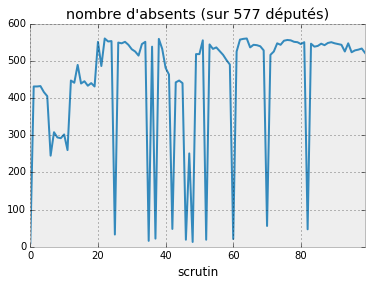

In [15]:
df.absents.plot()
plt.xlabel('scrutin')
plt.title("nombre d'absents (sur 577 députés)")

Afin de mieux appréhender cette distribution, regardons l'histogramme des absences :

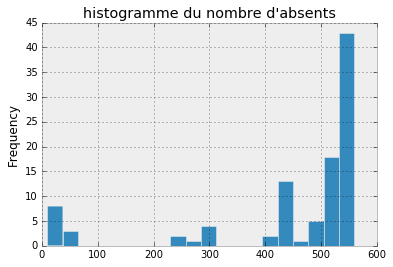

In [16]:
df.absents.plot(kind='hist', bins=20)
plt.title("histogramme du nombre d'absents")

On observe une distribution étrange : à gauche des scrutins avec peu d'absents (quelques uns), au milieu des scrutins à mi-assemblée (un peu moins) et beaucoup de scrutins avec beaucoup d'absents.

On peut s'intéresser aux dates des scrutins et rajouter l'information du jour de la semaine dans le tableau de données :

In [17]:
df.date = pd.to_datetime(df.date, dayfirst=True)

In [18]:
df.head(10)

,numero,date,objet,pour,contre,abstention,presents,absents
0,1237*,2016-02-10,l'ensemble du projet de loi constitutionnelle ...,317,199,51,567,10
1,1236,2016-02-09,l'ensemble de l'article premier du projet de l...,116,19,11,146,431
2,1235,2016-02-09,l'amendement n° 1 du Gouvernement à l'article ...,132,7,7,146,431
3,1234,2016-02-09,l'amendement n° 2 du Gouvernement à l'article ...,104,34,7,145,432
4,1233,2016-02-09,l'amendement n° 234 de M. Hamon après l'articl...,61,97,3,161,416
5,1232,2016-02-09,l'amendement n° 168 de M. Hamon après l'articl...,67,103,2,172,405
6,1231,2016-02-09,l'article 2 du projet de loi constitutionnelle...,162,148,22,332,245
7,1230,2016-02-09,le sous-amendement n° 271 de Mme Duflot et les...,59,185,25,269,308
8,1229,2016-02-09,le sous-amendement n° 250 de M. Goldberg et le...,77,174,32,283,294
9,1228,2016-02-09,l'amendement n° 50 de M. Schwartzenberg à l'ar...,64,180,41,285,292


Rajoutons le jour de la semaine à nos données :

In [19]:
day_mapping = {0: '01-lundi', 1: '02-mardi', 2: '03-mercredi', 
               3:'04-jeudi', 4: '05-vendredi', 5: '06-samedi', 6: '07-dimanche'}

In [20]:
df['jour'] = [day_mapping[date.dayofweek] for date in df.date]

In [21]:
df.head(10)

,numero,date,objet,pour,contre,abstention,presents,absents,jour
0,1237*,2016-02-10,l'ensemble du projet de loi constitutionnelle ...,317,199,51,567,10,03-mercredi
1,1236,2016-02-09,l'ensemble de l'article premier du projet de l...,116,19,11,146,431,02-mardi
2,1235,2016-02-09,l'amendement n° 1 du Gouvernement à l'article ...,132,7,7,146,431,02-mardi
3,1234,2016-02-09,l'amendement n° 2 du Gouvernement à l'article ...,104,34,7,145,432,02-mardi
4,1233,2016-02-09,l'amendement n° 234 de M. Hamon après l'articl...,61,97,3,161,416,02-mardi
5,1232,2016-02-09,l'amendement n° 168 de M. Hamon après l'articl...,67,103,2,172,405,02-mardi
6,1231,2016-02-09,l'article 2 du projet de loi constitutionnelle...,162,148,22,332,245,02-mardi
7,1230,2016-02-09,le sous-amendement n° 271 de Mme Duflot et les...,59,185,25,269,308,02-mardi
8,1229,2016-02-09,le sous-amendement n° 250 de M. Goldberg et le...,77,174,32,283,294,02-mardi
9,1228,2016-02-09,l'amendement n° 50 de M. Schwartzenberg à l'ar...,64,180,41,285,292,02-mardi


On peut donc désormais calculer des statistiques sur la base de cette information. Par exemple, regarder combien de scrutins ont eu lieu chaque jour de la semaine.

In [22]:
df.groupby('jour').size()

jour
01-lundi       10
02-mardi       38
03-mercredi    21
04-jeudi       21
05-vendredi    10
dtype: int64

On ne voit pas de scrutins le samedi ni le dimanche. Cela semble rassurant. Regardons la moyenne des présents et des absents sur ces jours :

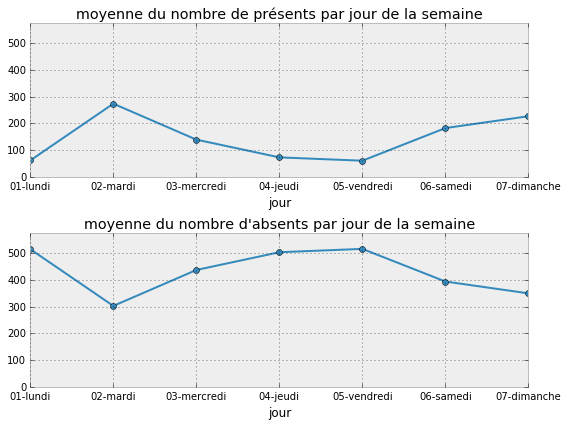

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

df.groupby('jour').mean()['presents'].plot(ax=ax[0], style='-o')
ax[0].set_ylim(0, 577)
ax[0].set_title("moyenne du nombre de présents par jour de la semaine")

df.groupby('jour').mean()['absents'].plot(ax=ax[1], style='-o')
ax[1].set_ylim(0, 577)
ax[1].set_title("moyenne du nombre d'absents par jour de la semaine")

plt.tight_layout()

On voit que le pic d'absents est le vendredi. Calculons le pourcentage d'absentéisme, c'est-à-dire divisons le nombre précédent par 577 députés.

(0, 100)

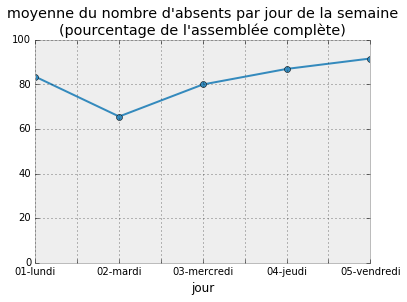

In [24]:
(df.groupby('jour').mean()['absents'] / 577 * 100).plot(style='-o')
plt.title("moyenne du nombre d'absents par jour de la semaine\n(pourcentage de l'assemblée complète)")
plt.ylim(0, 100)

Dans le graphique précédent, j'ai choisi de mettre l'échelle des ordonnées à 100% afin de montrer à quel point ces chiffres sont loins du 0% d'absents en moyenne.

Nous n'avons travaillé ici que sur des données partielles. Remontons dans le temps et téléchargeons toutes les données disponibles pour faire le travail ici présent.

# Récupération de tous les scrutins depuis 2012 

Pour faire ce travail, une simple boucle sur l'offset des scrutins permet de récupérer les données :

In [25]:
data = []
for offset in range(0, 1300, 100):
    url = "http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/{}/(legislature)/14/(type)/TOUS/(idDossier)/TOUS".format(offset)
    print(url)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    elems = soup.select('tbody tr')
    data += [extract_information(line) for line in elems]

http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/0/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/100/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/200/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/300/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/400/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/500/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/600/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/700/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/800/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee

In [26]:
len(data)

1237

On a désormais accès à 1237 scrutins depuis juillet 2012, date de la dernière élection législative.

Construisons le tableau des données détaillées : 

In [27]:
df = pd.DataFrame(data, columns=('numero', 'date', 'objet', 'pour', 'contre', 'abstention'))

In [28]:
df['presents'] = df['pour'] + df['contre'] + df['abstention']
df['absents'] = 577 - df.presents
df.date = pd.to_datetime(df.date, dayfirst=True)
df['jour'] = [day_mapping[date.dayofweek] for date in df.date]

Un aperçu de la fin du tableau :

In [29]:
df.tail(10)

,numero,date,objet,pour,contre,abstention,presents,absents,jour
1227,10,2012-07-19,l'article 27 du projet de loi de finances rect...,106,52,0,158,419,04-jeudi
1228,9,2012-07-19,l'amendement n° 477 rect présenté par M. de C...,24,108,13,145,432,04-jeudi
1229,8,2012-07-19,le sous-amendement n° 547 présenté par M. Bor...,29,119,5,153,424,04-jeudi
1230,7,2012-07-19,sur l'article 4 du projet de loi de finances r...,44,17,3,64,513,04-jeudi
1231,6,2012-07-19,L'amendement n° 467 de M. de Courson à l'ar...,24,90,0,114,463,04-jeudi
1232,5,2012-07-18,l'article 2 du projet de loi de finances recti...,89,64,0,153,424,03-mercredi
1233,4,2012-07-18,les amendements de suppression de l'alinéa 2 à...,88,177,0,265,312,03-mercredi
1234,3,2012-07-18,les amendements de suppression de l'article 2 ...,81,178,1,260,317,03-mercredi
1235,2,2012-07-17,l'article 1er du projet de loi de finances rec...,61,48,1,110,467,02-mardi
1236,1,2012-07-03,la déclaration de politique générale du gouver...,302,225,17,544,33,02-mardi


Traçons l'histogramme du nombre de présents :

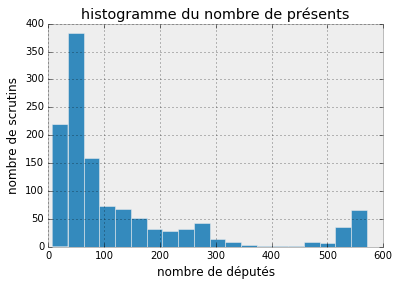

In [30]:
df.presents.plot(kind='hist', bins=20)
plt.title("histogramme du nombre de présents")
plt.xlabel("nombre de députés")
plt.ylabel("nombre de scrutins")

On voit que les députés sont absents, en moyenne, lors des scrutins avec une masse de scrutins avec faible présence, à gauche, et quelques scrutins avec beaucoup de députés.

Un histogramme cumulé permet d'interpréter plus facilement ces données :

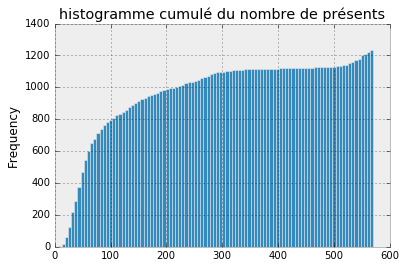

In [31]:
df.presents.plot(kind='hist', cumulative=True, bins=100)
plt.title("histogramme cumulé du nombre de présents")

Ce graphique permet de dire les choses suivants :

- il y a eu plus de 800 scrutins avec moins de 100 députés présents, depuis juillet 2012
- il y a eu plus de 1000 scrutins avec moins de 200 députés présents, depuis juillet 2012
- il y a une centainen de scrutins avec plus de 500 députés présents, depuis juillet 2012

In [32]:
df.presents.mean()

134.749393694422

En moyenne, sur les scrutins depuis juillet 2012, il y a avait 135 députés présents. Soit moins d'un quart de l'assemblée nationale.

On peut également répondre à la question : "quand les scrutins ont-ils lieu ?".

In [33]:
df.groupby('jour').size()

jour
01-lundi       181
02-mardi       280
03-mercredi    233
04-jeudi       295
05-vendredi    174
06-samedi       41
07-dimanche     33
dtype: int64

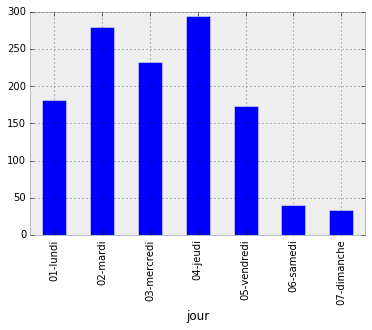

In [34]:
df.groupby('jour').size().plot(kind='bar')

Rien d'anormal : les scrutins ont lieu surtout les jours de la semaine, rarement le week-end. Pendant la semaine, ils ont lieu surtout le mardi et le jeudi.

Prochaine question : "quel jour de la semaine y a-t-il le plus d'absents lors des scrutins ?".

In [35]:
df.groupby('jour').mean()[['absents', 'presents']]

,absents,presents
jour,,
01-lundi,516.049724,60.950276
02-mardi,303.350000,273.650000
03-mercredi,438.141631,138.858369
04-jeudi,504.688136,72.311864
05-vendredi,517.235632,59.764368
06-samedi,394.829268,182.170732
07-dimanche,350.424242,226.575758


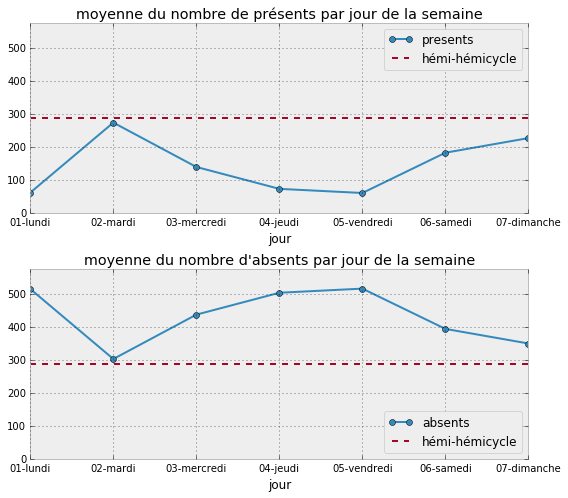

In [59]:
fig, ax = plt.subplots(2, 1, figsize=(8, 7))

df.groupby('jour').mean()['presents'].plot(ax=ax[0], style='-o', legend=True)
ax[0].set_ylim(0, 577)
ax[0].set_title("moyenne du nombre de présents par jour de la semaine")
ax[0].plot([0, 6], [577/2, 577/2], '--', label='hémi-hémicycle')
ax[0].legend()

df.groupby('jour').mean()['absents'].plot(ax=ax[1], style='-o', legend=True)
ax[1].set_ylim(0, 577)
ax[1].set_title("moyenne du nombre d'absents par jour de la semaine")
ax[1].plot([0, 6], [577/2, 577/2], '--', label='hémi-hémicycle')
ax[1].legend(loc='lower right')

plt.tight_layout()

On voit donc bien que les députés sont surtout absents lors des scrutins. En effet, en moyenne, on ne remplit jamais l'hémicycle.

On peut également représenter la courbe d'absentéisme en pourcentage :

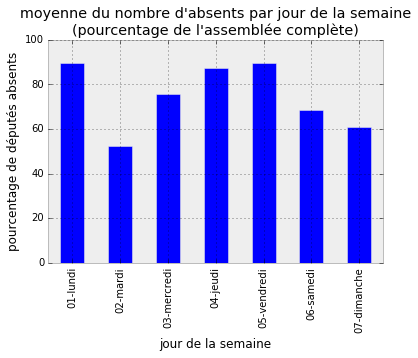

In [37]:
(df.groupby('jour').mean()['absents'] / 577 * 100).plot(kind='bar', style='-o')
plt.title("moyenne du nombre d'absents par jour de la semaine\n(pourcentage de l'assemblée complète)")
plt.ylim(0, 100)
plt.ylabel("pourcentage de députés absents")
plt.xlabel("jour de la semaine")

Nous avons donc répondu à la question principale qui se posait à nous : pour un scrutin moyen, combien de députés présents dans l'assemblée nationale. Penchons nous maintenant sur d'autres visualisations intéressantes.

# Quelques visualisations intéressantes 

## Pour et contre 

Une première visualisation intéressante vient des votes exprimés en fonction des suffrages. Si on place un point en fonction des votes pour et des votes contre, on obtient ceci :

(-10, 577)

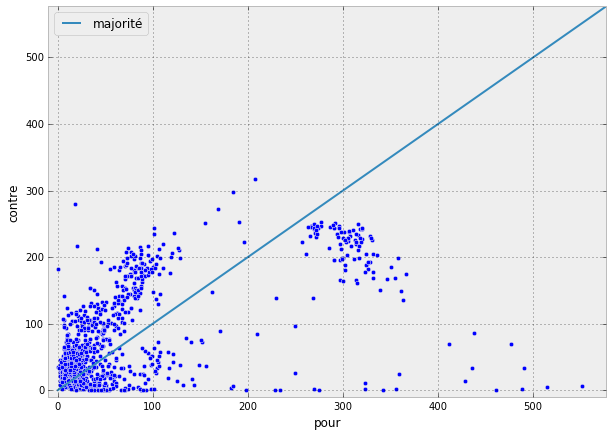

In [66]:
fig, ax = plt.subplots(figsize=(10, 7))
df.plot(ax=ax, kind='scatter', x='pour', y='contre')
plt.plot([0, 577], [0, 577], label='majorité')
plt.legend(loc='upper left')
plt.ylim(-10, 577)
plt.xlim(-10, 577)

La droite de la majorité sépare le graphique en deux régions. En particulier, on peut distinguer les régions suivantes :

- la droite horizontale qui passe par 0 : des scrutins où tout le monde est d'accord pour voter pour
- des scrutins autour de (300, 200) : des scrutins assez débattus, mais où il y a une majorité claire
- beaucoup de scrutins avec peu de députés (zone en bas à gauche) : pas de tendance claire

On peut s'intéresser aux scrutins avec une forte participation. En dessinant les points concernants dans le graphe précédent à l'aide d'une autre couleur, on trouve ceci :

(-10, 577)

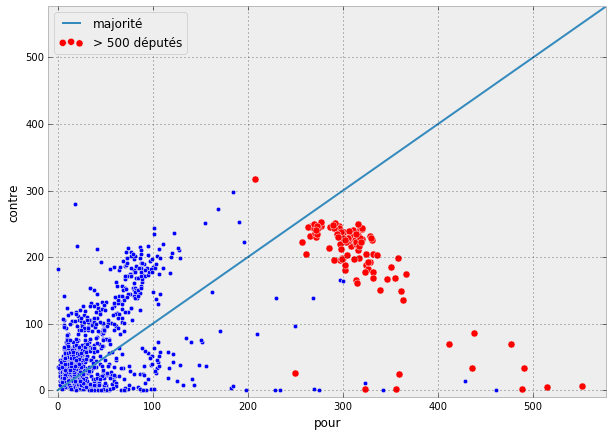

In [73]:
fig, ax = plt.subplots(figsize=(10, 7))
df.plot(ax=ax, kind='scatter', x='pour', y='contre')
df[df.presents > 500].plot(ax=ax, kind='scatter', x='pour', y='contre', color='Red', s=50, label='> 500 députés')
plt.plot([0, 577], [0, 577], label='majorité')
plt.legend(loc='upper left')
plt.ylim(-10, 577)
plt.xlim(-10, 577)

On voit que dans les votes à forte participation, très peu n'ont pas donné lieu à un vote majoritaire pour. Ceci reflète le fait que le parti socialiste dispose d'une majorité à l'assemblée nationale depuis les législatives de 2012.

On peut d'ailleurs s'intéresser au vote à forte participation qui n'a pas donné lieu à une majorité de pour :

In [74]:
df[(df.presents > 500) & (df.contre > df.pour)]

,numero,date,objet,pour,contre,abstention,presents,absents,jour
1180,57,2012-11-13,la demande de constitution d'une commission sp...,207,317,0,524,53,02-mardi


Il s'agit de "la demande de constitution d'une commission spéciale présentée par le président du groupe de l'Union pour un mouvement populaire pour l'examen du projet de loi ouvrant le mariage aux couples de personnes de même sexe". 

## Les thématiques 

On peut essayer de dresser un tableau comparatif des mots les plus utilisés pour les scrutins de plus de 500 députés participants ainsi que pour les scrutins de moins de 500 députés.

In [94]:
big = df[df.presents > 500]
small = df[df.presents <= 500]

In [95]:
from collections import Counter

def summarize(df):
    """Affiche les mots qui reviennent le plus dans les objets des scrutins."""
    c = Counter()
    for obj in df['objet']:
        c.update(obj.split(' '))
    return c.most_common(100)

In [96]:
summarize(big)[:20]

[('de', 242),
 ('du', 205),
 ('la', 112),
 ('scrutin]', 108),
 ('[analyse', 108),
 ('[dossier]', 100),
 ('loi', 99),
 ('projet', 93),
 ("l'ensemble", 78),
 ('à', 53),
 ('et', 49),
 ('le', 46),
 ('lecture).', 42),
 ('relatif', 38),
 ('pour', 37),
 ('des', 37),
 ('(première', 30),
 ('', 17),
 ('conseillers', 17),
 ('finances', 17)]

In [97]:
summarize(small)[:20]

[('de', 3973),
 ('du', 2466),
 ('à', 1290),
 ('scrutin]', 1129),
 ('[analyse', 1129),
 ('[dossier]', 1125),
 ('loi', 1063),
 ("l'article", 1053),
 ('et', 994),
 ('la', 991),
 ('projet', 985),
 ('n°', 984),
 ("l'amendement", 874),
 ('M.', 733),
 ('les', 533),
 ('amendements', 475),
 ('identiques', 402),
 ('des', 324),
 ('relatif', 323),
 ('pour', 320)]

Etant donné que beaucoup de mots sont communs ont va prendre l'intersection des mots fréquents et la soustraire aux deux listes de mots pour extraire les mots pertinents :

In [103]:
common = set([item[0] for item in summarize(small)]) & set([item[0] for item in summarize(big)])

In [104]:
common

{'',
 '(nouvelle',
 '(première',
 '2014',
 '2014.',
 '2015',
 'Gouvernement',
 'République',
 '[analyse',
 '[dossier]',
 'au',
 'aux',
 'calendrier',
 'conseillers',
 'couples',
 'de',
 'des',
 'du',
 'délimitation',
 'départementales',
 'en',
 'et',
 'financement',
 'finances',
 "l'article",
 "l'élection",
 'la',
 'le',
 'lecture).',
 'les',
 'loi',
 'mariage',
 'modernisation',
 'modifiant',
 'même',
 'par',
 'personnes',
 'portant',
 'pour',
 'projet',
 'proposition',
 'publique',
 'rectificative',
 'relatif',
 'relative',
 'régionales',
 'régions,',
 'scrutin]',
 'sociale',
 'sur',
 'système',
 'sécurité',
 'à',
 'élections',
 'électoral'}

Ceci nous permet d'obtenir la liste des mots suivants pour les "grands scrutins" :

In [108]:
[(word, freq) for word, freq in summarize(big) \
            if word in set([item[0] for item in summarize(big)]) - common]

[("l'ensemble", 78),
 ('organique', 13),
 ('programmation', 8),
 ('avec', 7),
 ('cumul', 7),
 ('vie', 7),
 ('mandat', 7),
 ('locales', 6),
 ('application', 6),
 ('fonctions', 6),
 ('interdisant', 6),
 ('(lecture', 6),
 ('transparence', 6),
 ('déclaration', 6),
 ('Constitution).', 6),
 ('exécutives', 6),
 ('alinéa', 5),
 ('départementaux,', 5),
 ('définitive).', 5),
 ('municipaux', 5),
 ('dispositions', 4),
 ('(1ère', 4),
 ('député', 3),
 ('ouvrant', 3),
 ('réforme', 3),
 ('49,', 3),
 ('2013.', 3),
 ('ou', 3),
 ('politique', 3),
 ('2016', 3),
 ('constitutionnelle', 3),
 ('diverses', 3),
 ('économique', 3),
 ('représentant', 3),
 ("l'emploi", 3),
 ('logement', 3),
 ('années', 3),
 ('lecture)', 3),
 ('50-1', 3),
 ('(en', 3),
 ('Parlement', 3),
 ('générale', 3),
 ('président', 2),
 ('concernant', 2),
 ('nomination', 2)]

Et les petits : 

In [109]:
[(word, freq) for word, freq in summarize(small) \
            if word in set([item[0] for item in summarize(small)]) - common]

[('n°', 984),
 ("l'amendement", 874),
 ('M.', 733),
 ('amendements', 475),
 ('identiques', 402),
 ('Mme', 301),
 ('après', 215),
 ('Fraysse', 199),
 ('4', 189),
 ('sécurisation', 173),
 ("l'emploi.", 170),
 ('ouverture', 153),
 ('premier', 130),
 ('2', 114),
 ('sexe.', 109),
 ('Le', 100),
 ('sexe', 75),
 ('1er', 75),
 ('bis', 73),
 ('3', 72),
 ('Fur', 68),
 ('justice', 65),
 ('garantissant', 64),
 ("l'avenir", 64),
 ('Sénat,', 63),
 ('Poisson', 59),
 ('14', 58),
 ('suppression', 58),
 ('loi,', 56),
 ('motion', 55),
 ('retraites.', 54),
 ('territoriale', 52),
 ('avant', 50),
 ('13', 46),
 ('visant', 44),
 ('nouvelle', 40),
 ('ses', 39),
 ('organisation', 38),
 ('collègues', 38),
 ('adopté', 37),
 ("l'égalité", 36),
 ('12', 35),
 ('unique', 35),
 ('identique', 35),
 ('croissance,', 32)]

On retrouve donc des thématiques majeures, comme les lois de programmation, la transparence, le cumul des mandats mais aussi des thématiques que l'on pourrait qualifier de mineures comme le sexe, les retraites, la croissance, Mme Fraysse.

## Nombre de scrutins par jour 

Une autre question que l'on peut se poser est celle du nombre de scrutins par jour. Combien de scrutins par jour donné, en moyenne ? 

In [113]:
s = df.groupby('date').size()

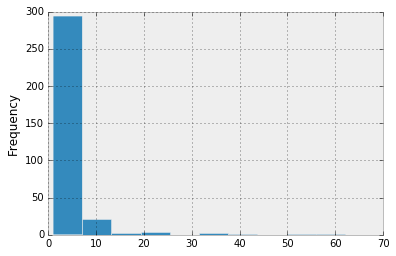

In [114]:
s.plot(kind='hist')

En général, il y a peu de scrutins par jour, mais il existe des jours exceptionnels :

In [117]:
s.sort_values(ascending=False)

date
2013-04-08    62
2013-04-05    51
2013-02-06    39
2013-04-04    36
2013-02-03    33
2013-02-05    24
2013-02-02    24
2013-10-11    22
2014-06-16    20
2013-02-07    17
2013-10-08    14
2013-11-20    13
2014-07-01    13
2013-02-08    13
2013-04-11    12
2013-02-04    12
2013-04-03    12
2016-02-09    11
2013-10-21    11
2013-07-19    11
2013-03-28    11
2015-03-17    11
2014-10-17     9
2013-04-06     9
2013-02-22     8
2013-03-14     8
2013-06-26     8
2015-02-14     8
2013-12-11     8
2014-05-22     8
              ..
2015-12-01     1
2015-03-19     1
2015-12-03     1
2015-12-08     1
2016-01-14     1
2016-02-03     1
2015-10-27     1
2013-10-01     1
2015-07-15     1
2015-06-23     1
2015-01-26     1
2015-01-27     1
2015-01-28     1
2015-01-30     1
2015-02-05     1
2015-02-20     1
2015-03-11     1
2015-03-12     1
2015-06-24     1
2015-03-18     1
2015-03-31     1
2015-04-01     1
2015-04-15     1
2015-05-05     1
2015-05-19     1
2015-05-27     1
2015-06-02     1
2015-06-1

Que s'est-il passé en avril 2013 ? Il semblerait qu'il y ait une journée avec 62 scrutins.

In [119]:
df[df.date == '2013-04-08']

,numero,date,objet,pour,contre,abstention,presents,absents,jour
757,480,2013-04-08,l'amendement n°1 du Gouvernement à l'article 8...,46,21,3,70,507,01-lundi
758,479,2013-04-08,l'article 18 du projet de loi relatif à la séc...,49,7,11,67,510,01-lundi
759,478,2013-04-08,l'amendement n°3451 de Mme Fraysse et les amen...,5,52,0,57,520,01-lundi
760,477,2013-04-08,l'amendement n°2602 de Mme Fraysse et les amen...,5,47,3,55,522,01-lundi
761,476,2013-04-08,l'article 17 du projet de loi relatif à la sé...,75,8,1,84,493,01-lundi
762,475,2013-04-08,l'article 16 du projet de loi relatif à la sé...,55,19,12,86,491,01-lundi
763,474,2013-04-08,l'amendement n°3400 de Mme Fraysse et les amen...,8,60,1,69,508,01-lundi
764,473,2013-04-08,l'amendement n°3092 de Mme Fraysse et les amen...,10,64,0,74,503,01-lundi
765,472,2013-04-08,l'amendement n°5045 de Mme Fraysse et les amen...,9,62,4,75,502,01-lundi
766,471,2013-04-08,l'amendement n°3047 de Mme Fraysse et les amen...,30,47,0,77,500,01-lundi


On peut relire une partie des échanges de cette journée [ici](http://www.assemblee-nationale.fr/14/cri/2012-2013/20130208.asp). Il semblerait que ces amendements soient des amendements de cohérence. On peut imaginer le déroulement de cette journée en dessinant les votes au fur et à mesure :

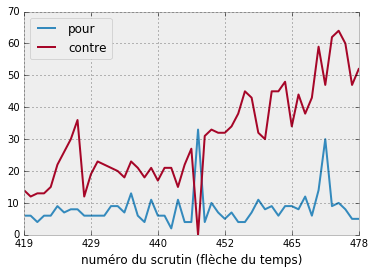

In [130]:
selection = (df.date == '2013-04-08') & df.objet.str.contains('Fraysse')
fig, ax = plt.subplots()
df[selection].plot.line(ax=ax, x='numero', y='pour')
df[selection].plot.line(ax=ax, x='numero', y='contre')
ax.set_xlabel('numéro du scrutin (flèche du temps)')
ax.invert_xaxis()

On imagine bien l'assemblée se remplir au fur et à mesure de la journée du 8 avril. La plupart des amendements proposés par Mme Fraysse ont malheureusement été rejetés, sauf un.

# Conclusions

Comme on a pu le découvrir dans cette note, des données très riches sont accessibles pour imaginer le travail de l'assemblée nationale. Ce qui est plus difficile, c'est d'en tirer des conclusions solides. On pourra tout de même retenir que l'essentiel des scrutins de l'assemblée ne sont pas suivis par les députés. Seuls les très gros scrutins le sont, et ceux-ci sont généralement adoptés (dans le cadre de la législature actuelle).